In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

In [2]:
%load_ext autoreload
%autoreload 2

# Steps to convert 1st set of ABF files
- read in metadata
- identify files to be converted (from mouse2019, using protocols testing intrinsic properties, ABFv2)
- merge in extracted metadata
- convert using modified ABF2Converter
- validate NWB outputs using dandi-cli
- explore errors

## Read in metadata provided by Homeira
- Focus on files testing intrinsic properties
- we find 73 ABF files that suit these criteria
- later we will read in files and determine whether they are ABFv1 or ABFv2

In [3]:
mouse_meta = pd.read_csv('./data/raw/Metadata/Mouse19_Metadatav2.csv')
mouse_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
mouse_meta.shape

(125, 13)

In [5]:
mouse_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,19o22017,Mouse,Oct 22_2019,C2,L5,Firing,After ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0
1,19o22001,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0
2,19o22031,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0
3,19o22037,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0
4,19o22018,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0


In [6]:
mouse_meta['Stim Type'].value_counts()

Firing         58
White noise    52
Gap free        5
Firing rate     5
ZAP             3
GAP free        1
n.a             1
Name: Stim Type, dtype: int64

In [7]:
intrinsic_meta = mouse_meta[(mouse_meta['Stim Type'] == 'Firing') | (mouse_meta['Stim Type'] == 'Firing rate')]

In [8]:
intrinsic_meta['Stim Type'].value_counts()

Firing         58
Firing rate     5
Name: Stim Type, dtype: int64

## Identify files to be converted
- ABF files from human2019
- need metadata to determine which files are testing intrinsic properties
- extract ABF version info, time of creation and comments from the ABF file

In [9]:
mouse2019_abf_dir = Path("./data/raw/recordings/Mouse data/Mouse data_2019/")
mouse2019_file_info = utils.summary_df(mouse2019_abf_dir)

In [10]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

mouse2019_file_info['timestamp'] = mouse2019_file_info.path.apply(parse_timestamp)
mouse2019_file_info['abf_version'] = mouse2019_file_info.path.apply(extract_abf_version)
mouse2019_file_info['abf_comments'] = mouse2019_file_info.path.apply(extract_abf_comments)

# add this column to merge with provided metadata
mouse2019_file_info['file_id'] = mouse2019_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 3.66 s, sys: 1.44 s, total: 5.1 s
Wall time: 5.74 s


In [11]:
mouse2019_file_info.shape

(145, 6)

In [12]:
mouse2019_file_info.head()

,file_name,path,timestamp,abf_version,abf_comments,file_id
0,19o09012.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 13:09:53.859,2.6.0.0,"[C3, L5, APV, CNQX, 4AP, PTX]",19o09012
1,19o09010.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 13:08:47.640,2.6.0.0,"[C3, L5, APV, CNQX, 4AP, PTX, Command signal h...",19o09010
2,19o09011.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 13:09:10.109,2.6.0.0,"[C3, L5, APV, CNQX, 4AP, PTX]",19o09011
3,19o09049.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 15:16:04.750,2.6.0.0,"[C7, L5, APV, CNQX, 4AP, PTX,]",19o09049
4,19o09048.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-09 15:15:56.718,2.6.0.0,"[C7, L5, APV, CNQX, 4AP, PTX,]",19o09048


In [13]:
mouse2019_file_info.abf_version.value_counts()

2.6.0.0    142
1.8.4.0      3
Name: abf_version, dtype: int64

## Merge metadata with extracted information about ABF files

In [14]:
intrinsic_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,19o22017,Mouse,Oct 22_2019,C2,L5,Firing,After ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0
1,19o22001,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0
2,19o22031,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0
3,19o22037,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0
4,19o22018,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0


In [15]:
intrinsic_meta.shape

(63, 13)

In [16]:
merged_meta = intrinsic_meta.merge(mouse2019_file_info, left_on='Cell Name', right_on='file_id' , how='left')

In [17]:
merged_meta.shape

(63, 19)

In [18]:
# we are left with 36 files to convert
merged_meta.abf_version.value_counts()

2.6.0.0    50
Name: abf_version, dtype: int64

In [19]:
merged_meta[merged_meta.path.isna()]

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,timestamp,abf_version,abf_comments,file_id
7,19o22042,Mouse,Oct 22_2019,C4,L5,Firing,Before ZD,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0,NaN,NaN,NaT,NaN,NaN,NaN
8,19o23023,Mouse,Oct 23_2019,C4,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-62.0,NaN,NaN,NaT,NaN,NaN,NaN
10,19o23017,Mouse,Oct 23_2019,C4,L5-Int,Firing,Before ZD,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-63.0,NaN,NaN,NaT,NaN,NaN,NaN
12,19o23067,Mouse,Oct 23_2019,C8,L5,Firing,After ZD,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-71.0,NaN,NaN,NaT,NaN,NaN,NaN
13,19o23068,Mouse,Oct 23_2019,C8,L5,Firing,After ZD,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-68.0,NaN,NaN,NaT,NaN,NaN,NaN
14,19o23069,Mouse,Oct 23_2019,C8,L5,Firing,After ZD,NaN,1.0,0.0,Vm_Sec (mV),IN 10(pA),-70.0,NaN,NaN,NaT,NaN,NaN,NaN
16,2019_10_24_0033,Mouse,Oct 24_ 2019_CA,C1,L5,Firing,After CA,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-65.0,NaN,NaN,NaT,NaN,NaN,NaN
17,2019_10_24_0034,Mouse,Oct 24_ 2019_CA,C1,L5,Firing,After CA,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0,NaN,NaN,NaT,NaN,NaN,NaN
19,2019_10_24_0001,Mouse,Oct 24_ 2019_CA,C1,L5,Firing,Before CA,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-65.0,NaN,NaN,NaT,NaN,NaN,NaN
20,2019_10_24_0002,Mouse,Oct 24_ 2019_CA,C1,L5,Firing,Before CA,NaN,1.0,0.0,Vm_Sec (mV),IN 11(pA),-65.0,NaN,NaN,NaT,NaN,NaN,NaN


In [20]:
merged_meta[~merged_meta.path.isna()]

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,timestamp,abf_version,abf_comments,file_id
0,19o22017,Mouse,Oct 22_2019,C2,L5,Firing,After ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0,19o22017.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 15:32:34.890,2.6.0.0,"[C2, L5, APV,CNQX,PTX,, ZD7288 10 uM, 20 min a...",19o22017
1,19o22001,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0,19o22001.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 15:02:02.515,2.6.0.0,"[C2, L5, APV,CNQX,PTX]",19o22001
2,19o22031,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0,19o22031.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:21:52.859,2.6.0.0,"[ZD7288 10 uM, added 10 min ago, C3, L5, APV,C...",19o22031
3,19o22037,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0,19o22037.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:30:25.265,2.6.0.0,"[C3, L5, APV,CNQX,PTX,]",19o22037
4,19o22018,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0,19o22018.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:07:18.140,2.6.0.0,"[C3, L5, APV,CNQX,PTX]",19o22018
5,19o22019,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0,19o22019.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:07:26.046,2.6.0.0,"[C3, L5, APV,CNQX,PTX]",19o22019
6,19o22020,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-77.0,19o22020.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:08:20.078,2.6.0.0,[],19o22020
9,19o23033,Mouse,Oct 23_2019,C4,L5-Int,Firing,After ZD,NaN,1.0,0.0,Vm_Sec (mV),IN 10(pA),-60.0,19o23033.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-23 13:59:09.718,2.6.0.0,"[C4, L5, APV,CNQX,PTX,,ZD 10 uM,]",19o23033
11,19o23019,Mouse,Oct 23_2019,C4,L5,Firing,Before ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 10(pA),-62.0,19o23019.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-23 13:41:10.593,2.6.0.0,"[C4, L5, APV,CNQX,PTX,]",19o23019
15,19o23056,Mouse,Oct 23_2019,C8,L5,Firing,Before ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 10(pA),-68.0,19o23056.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-23 15:21:29.171,2.6.0.0,"[C8, L5, APV,CNQX,PTX,]",19o23056


In [21]:
to_convert = merged_meta[~merged_meta.path.isna()]

In [22]:
to_convert.shape

(50, 19)

## Convert!
- 36 files to convert to NWB

In [23]:
output_dir = Path("data/processed/recordings/mouse2019")
output_dir.mkdir(exist_ok=True)

In [24]:
to_convert.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,timestamp,abf_version,abf_comments,file_id
0,19o22017,Mouse,Oct 22_2019,C2,L5,Firing,After ZD,shortsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-66.0,19o22017.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 15:32:34.890,2.6.0.0,"[C2, L5, APV,CNQX,PTX,, ZD7288 10 uM, 20 min a...",19o22017
1,19o22001,Mouse,Oct 22_2019,C2,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-64.0,19o22001.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 15:02:02.515,2.6.0.0,"[C2, L5, APV,CNQX,PTX]",19o22001
2,19o22031,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-70.0,19o22031.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:21:52.859,2.6.0.0,"[ZD7288 10 uM, added 10 min ago, C3, L5, APV,C...",19o22031
3,19o22037,Mouse,Oct 22_2019,C3,L5,Firing,After ZD,ramp,1.0,0.0,Vm_Sec (mV),IN 11(pA),-67.0,19o22037.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:30:25.265,2.6.0.0,"[C3, L5, APV,CNQX,PTX,]",19o22037
4,19o22018,Mouse,Oct 22_2019,C3,L5,Firing,Before ZD,longsquare,1.0,0.0,Vm_Sec (mV),IN 11(pA),-75.0,19o22018.abf,data/raw/recordings/Mouse data/Mouse data_2019...,2019-10-22 16:07:18.140,2.6.0.0,"[C3, L5, APV,CNQX,PTX]",19o22018


In [25]:
to_convert.shape

(50, 19)

In [26]:
def get_stim_chan(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.dacNames[1]

def get_resp_chan(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.adcNames[0]

In [27]:
to_convert['stim_chan'] = to_convert.path.apply(get_stim_chan)
to_convert['resp_chan'] = to_convert.path.apply(get_resp_chan)

<ipython-input-27-ef420d1da0b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_convert['stim_chan'] = to_convert.path.apply(get_stim_chan)
<ipython-input-27-ef420d1da0b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_convert['resp_chan'] = to_convert.path.apply(get_resp_chan)


In [28]:
from x_to_nwb import ABF2Converter

def generate_subject_meta(row):
    meta = {
    'Subject': {
        'age': None,
        'description': f'{row.abf_comments}',
        'species': 'Homo sapiens',
        'subject_id': f'Donor_{row.file_id}'}
    }
    return meta


def convert_abfv2_row(row):
    abf = pyabf.ABF(row.path)
    file_stem = row.file_id
    output_path = output_dir / f'{file_stem}.nwb'
    meta = generate_subject_meta(row)
    print(f'Subject meta: {meta}')
    print(f'Stimulus chan: {row.stim_chan}')
    print(f'Response chan: {row.resp_chan}')

    nwb = ABF2Converter.ABF2Converter(row.path,
                                      str(output_path), 
                                      includeChannelList=[row.resp_chan],
                                      stimulus_name=row.stim_chan,
                                      metadata=meta)

    print(f"NWB Conversion complete for {output_path}")

In [29]:
successes = []
errors = []

for i, row in to_convert.iterrows():
    try:
        convert_abfv2_row(row)
        successes.append((row.file_id, row.path))
    except (ValueError, IndexError, TypeError, KeyError) as e:
        print('**'*50)
        print(f'Error: {e} \n {row.path} \n')
        errors.append((e, row.file_id, row.path))

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/After ZD/19o22017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,', 'ZD7288 10 uM, 20 min ago added', 'ZD7288 10 uM, 23 min ago added']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22017'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset I-V curve ,-400 pA, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:550: UserWarning: Could not find settings for amplifier unknown of channel Vm_sec.
  warnings.warn(f"Could not find settings for amplifier {amplifier} of channel {adcName}.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C2_L5/Firing/Before ZD/19o22001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22017.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22001'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/After ZD/19o22031.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22001.nwb
Subject meta: {'Subject': {'age': None, 'description': "['ZD7288 10 uM, added 10 min ago', 'C3, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22031'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/After ZD/19o22037.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22031.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22037'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset Ramp 1S-190-330-20, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22037.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22018'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22019.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22018.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22019'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 22_2019/C3_L5/Firing/Before ZD/19o22020.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22019.nwb
Subject meta: {'Subject': {'age': None, 'description': '[]', 'species': 'Homo sapiens', 'subject_id': 'Donor_19o22020'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C4_L5/Firing/After ZD/19o23033.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o22020.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, APV,CNQX,PTX,,ZD 10 uM,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23033'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C4_L5/Firing/Before ZD/19o23019.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23033.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23019'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C8_L5/Firing/Before ZD/19o23056.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23019.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C8, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23056'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C1_L5/Firing/After CA/2019_10_24_0035.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23056.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C1, L5, APV,CNQX,PTX, CA 50 nM , Gain 40, Dc 20 pA']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0035'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C3_L5/Firing/After CA/2019_10_24_0063.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0035.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX, CA 50 nM']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0063'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C3_L5/Firing/Before CA/2019_10_24_0050.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0063.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0050'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C1_L5/Firing/19o08001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0050.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C1, L5, SS, KA mice']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08001'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C1_L5/Firing/19o08002.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08001.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C1, L5, SS, KA mice']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08002'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C1_L5/Firing/19o08003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08002.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C1, L5, SS, KA mice, APV, CNQX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08003'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08003.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, SS, KA mice,RMP -67.8 mv']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08010'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08011.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08010.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, SS, KA mice,RMP -67.8 mv']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08011'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C2_L5/Firing/19o08012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08011.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, SS, KA mice,RMP -67.8 mv']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08012'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C3_L5/Firing/19o08017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08012.nwb
Subject meta: {'Subject': {'age': None, 'description': "['RMP -64.9 mV', 'C3, L5, SS, KA mice,RMP -67.8 mv, APV, CNQX, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08017'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C3_L5/Firing/19o08018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08017.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, SS, KA mice,RMP -67.8 mv, APV, CNQX, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08018'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C3_L5/Firing/19o08020.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08018.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, SS, KA mice,RMP -67.8 mv, APV, CNQX, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08020'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C4_L5/Firing/19o08025.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08020.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, SS, KA mice,RMP -68.2 mv, APV, CNQX, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08025'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C4_L5/Firing/19o08026.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08025.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, SS, KA mice,RMP -68.2 mv, APV, CNQX, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08026'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 08_ 2019_KA/C4_L5/Firing/19o08027.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08026.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, SS, KA mice,RMP -68.2 mv, APV, CNQX, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o08027'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C3_L5/Firing/19o09012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o08027.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV, CNQX, 4AP, PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09012'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C4_L5/Firing/19o09016.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09012.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, APV, CNQX, 4AP, PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09016'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C4_L5/Firing/19o09017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09016.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, APV, CNQX, 4AP, PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09017'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C4_L5/Firing/19o09018.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09017.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, APV, CNQX, 4AP, PTX']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09018'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C6_L5/Firing/19o09042.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09018.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C6, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09042'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C6_L5/Firing/19o09043.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09042.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C6, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09043'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09057.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09043.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C8, L5, APV, CNQX, 4AP, PTX, Dc 250, Gain 40', 'C8, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09057'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09058.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09057.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C8, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09058'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C8_L5/Firing/19o09059.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09058.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C8, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09059'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C1_L5/Firing/19o23001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09059.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C1, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23001'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23001.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23003'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23005.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23003.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23005'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C2_L5/Firing/19o23006.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23005.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23006'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C3_L5/Firing/19o23010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23006.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23010'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C3_L5/Firing/19o23012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23010.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C3, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23012'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C7_L5/Firing/19o23046.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23012.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C7, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23046'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C2_L5/Firing/2019_10_24_0037.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23046.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0037'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C2_L5/Firing/2019_10_24_0038.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0037.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0038'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C2_L5/Firing/2019_10_24_0039.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0038.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C2, L5, APV,CNQX,PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0039'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 24_ 2019_CA/C4_L5/Firing/2019_10_24_0073.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0039.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C4, L5, APV,CNQX,PTX,', 'C4, L5, APV,CNQX,PTX, RMP -82.6 mV']", 'species': 'Homo sapiens', 'subject_id': 'Donor_2019_10_24_0073'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C7_L5/Firing rate/19o09049.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/2019_10_24_0073.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C7, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09049'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 09_ 2019_4AP/C7_L5/Firing rate/19o09050.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09049.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C7, L5, APV, CNQX, 4AP, PTX,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o09050'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23039.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o09050.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C6, L5, APV,CNQX,PTX,,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23039'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23040.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23039.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C6, L5, APV,CNQX,PTX,,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23040'}}
Stimulus chan: I_clampsec
Response chan: Vm_sec


/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Mouse data/Mouse data_2019/Oct 23_2019/C6_L5/Firing rate/19o23041.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for data/processed/recordings/mouse2019/19o23040.nwb
Subject meta: {'Subject': {'age': None, 'description': "['C6, L5, APV,CNQX,PTX,,']", 'species': 'Homo sapiens', 'subject_id': 'Donor_19o23041'}}
Stimulus chan: Cmd 1
Response chan: Vm_sec
NWB Conversion complete for data/processed/recordings/mouse2019/19o23041.nwb


In [30]:
error_df = pd.DataFrame(errors, columns = ['error', 'file_id', 'path'])

In [31]:
error_df

,error,file_id,path


In [32]:
successes_df = pd.DataFrame(successes, columns = ['file_id', 'path'])
successes_df['nwb_path'] = successes_df.file_id.apply(lambda x: str(output_dir / f"{x}.nwb"))

In [33]:
successes_df.head()

,file_id,path,nwb_path
0,19o22017,data/raw/recordings/Mouse data/Mouse data_2019...,data/processed/recordings/mouse2019/19o22017.nwb
1,19o22001,data/raw/recordings/Mouse data/Mouse data_2019...,data/processed/recordings/mouse2019/19o22001.nwb
2,19o22031,data/raw/recordings/Mouse data/Mouse data_2019...,data/processed/recordings/mouse2019/19o22031.nwb
3,19o22037,data/raw/recordings/Mouse data/Mouse data_2019...,data/processed/recordings/mouse2019/19o22037.nwb
4,19o22018,data/raw/recordings/Mouse data/Mouse data_2019...,data/processed/recordings/mouse2019/19o22018.nwb


## Plotting converted files

loading dataset into data structure...
data/processed/recordings/mouse2019/19o22017.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22001.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22031.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22037.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22018.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22019.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o22020.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o23033.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o23019.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o23056.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/2019_10_24_0035.nwb
loading dataset into data

/Users/derek_howard/triplab/testingephys/nwb_conversion/utils.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2, 1, sharex=True)


loading dataset into data structure...
data/processed/recordings/mouse2019/19o08020.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08025.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08026.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o08027.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09012.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09016.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09017.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09018.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09042.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09043.nwb
loading dataset into data structure...
data/processed/recordings/mouse2019/19o09057.nwb
loading dataset into data struct

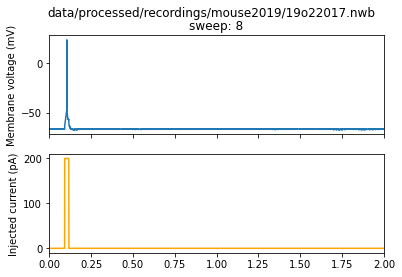

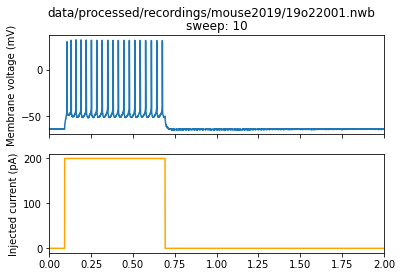

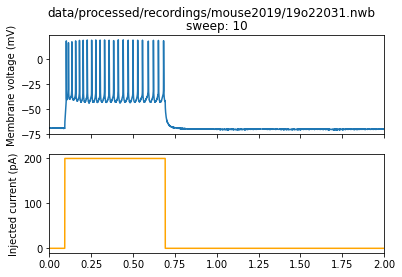

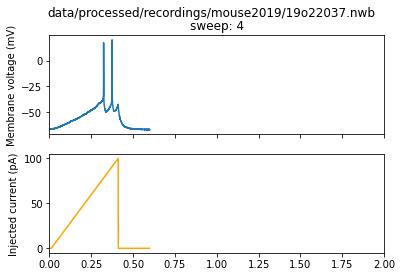

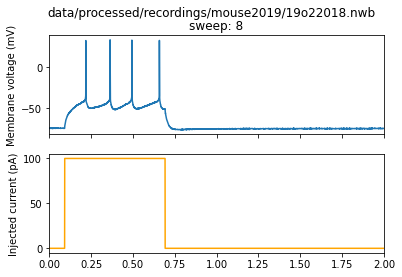

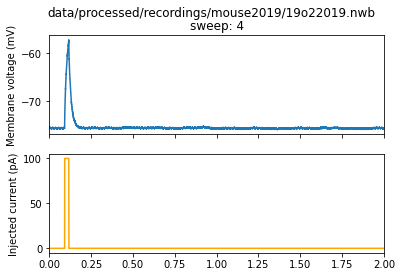

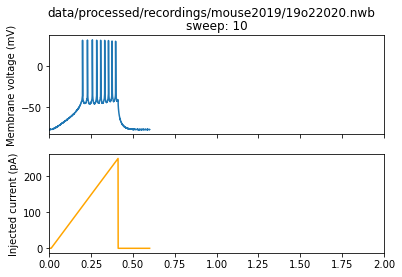

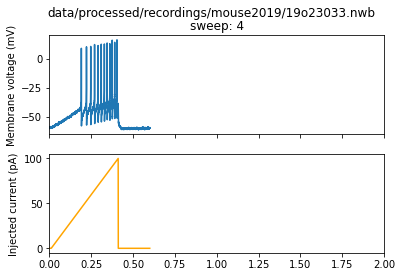

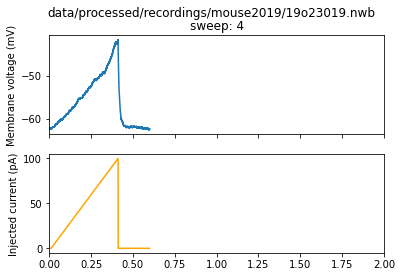

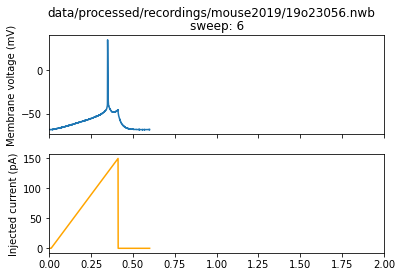

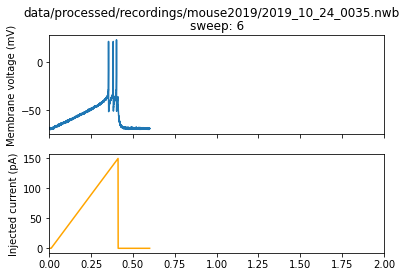

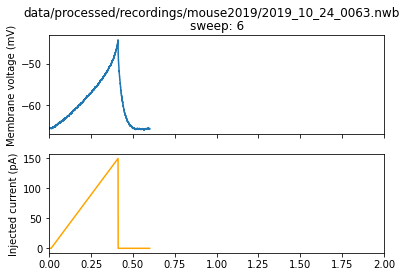

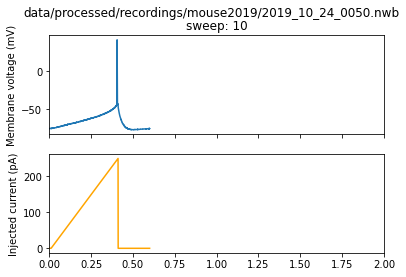

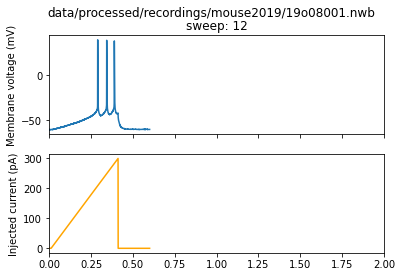

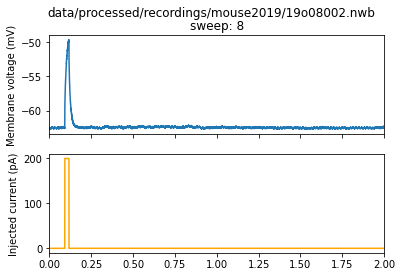

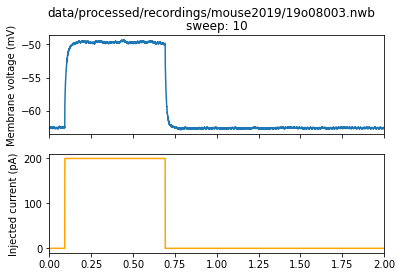

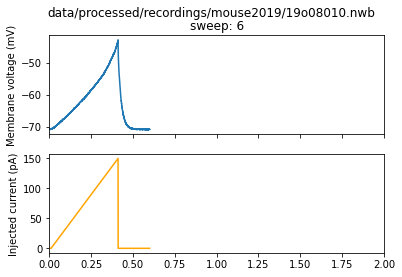

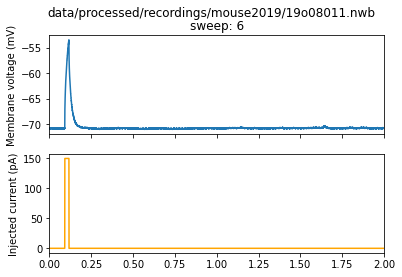

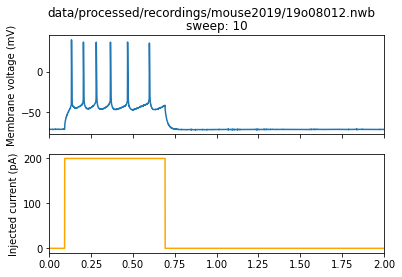

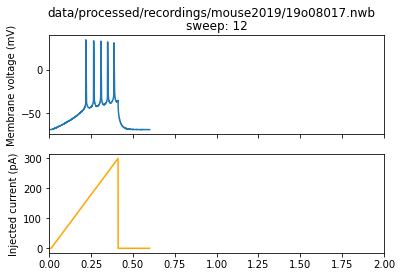

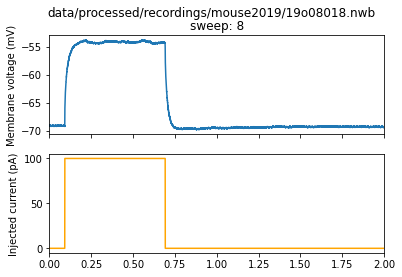

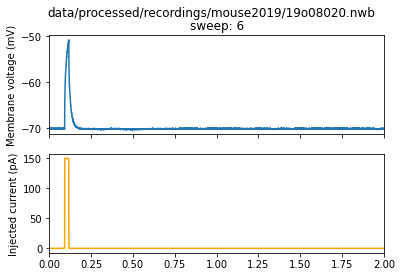

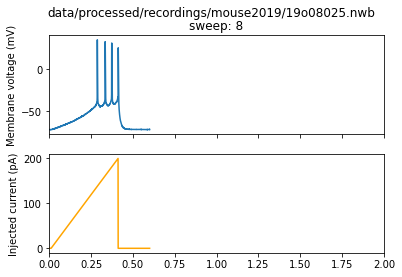

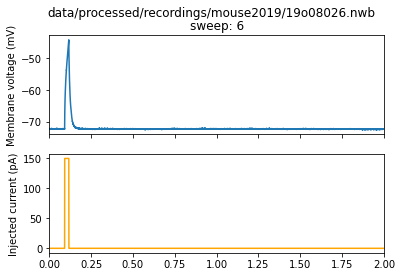

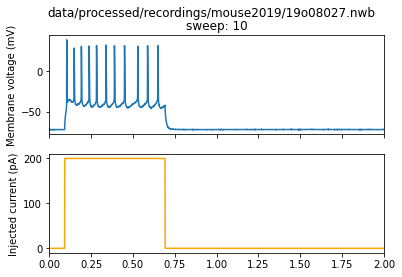

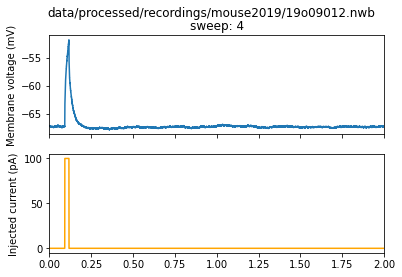

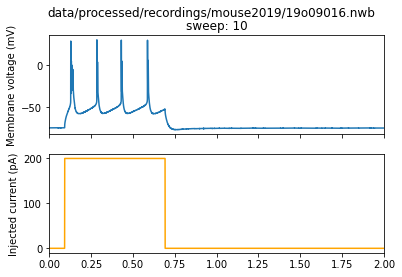

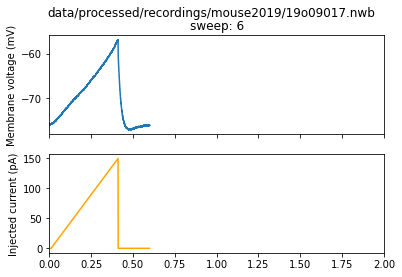

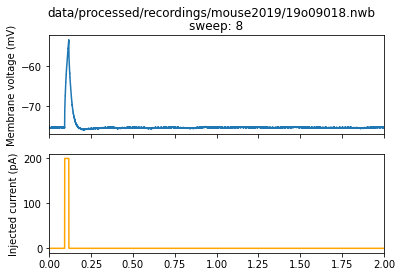

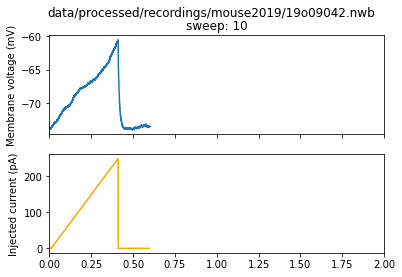

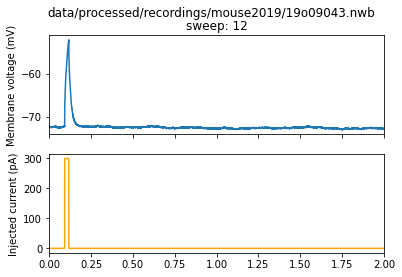

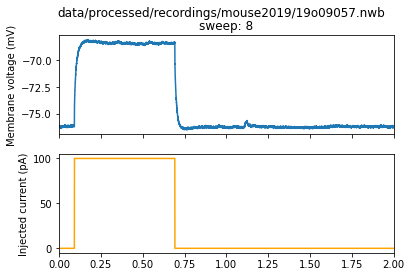

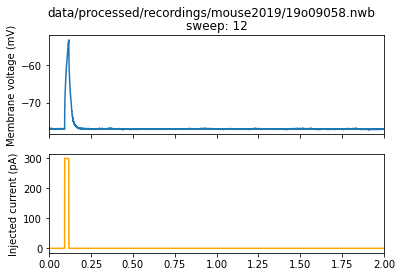

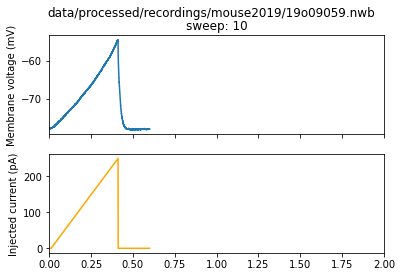

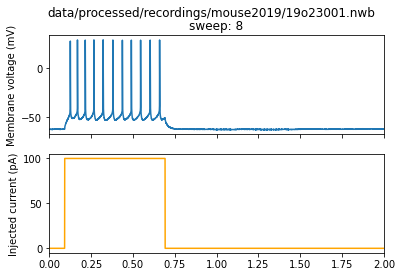

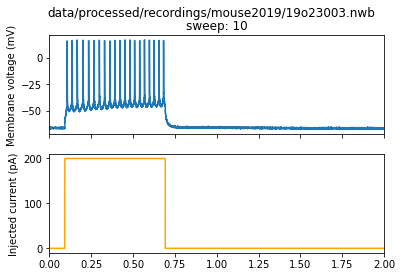

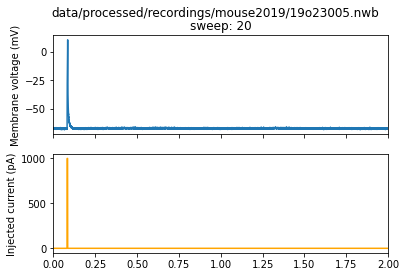

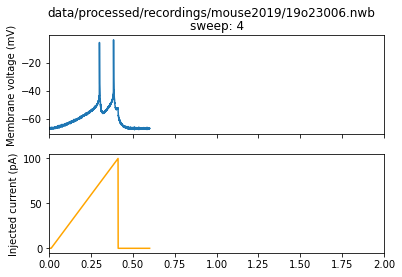

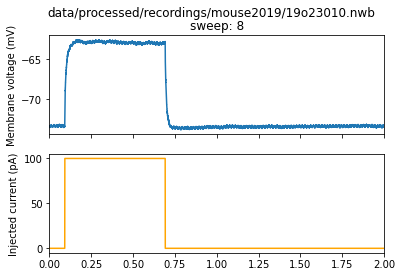

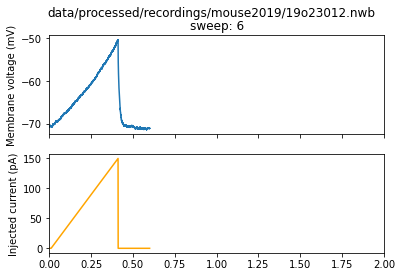

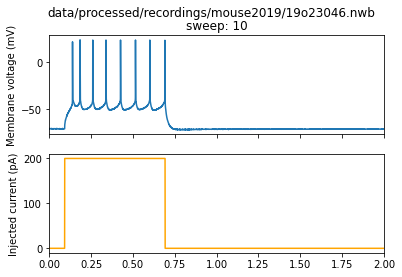

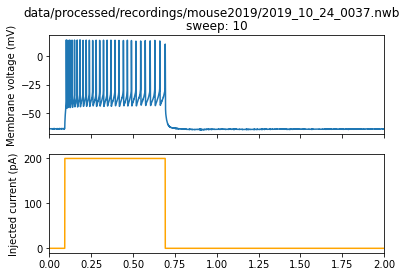

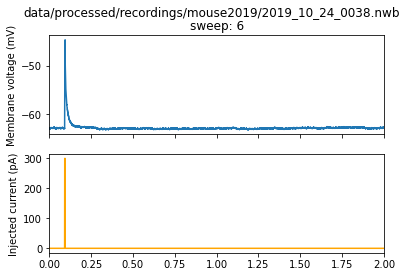

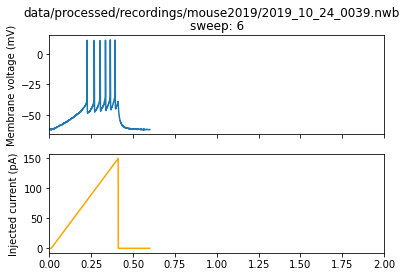

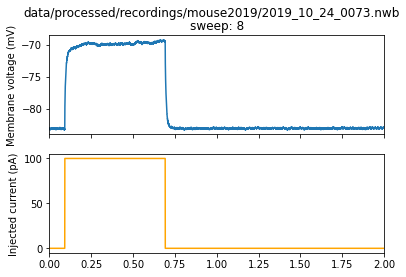

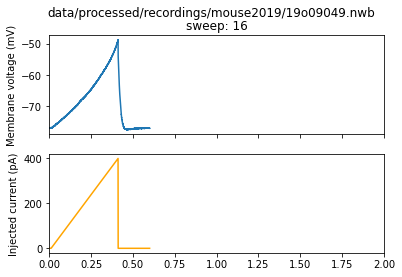

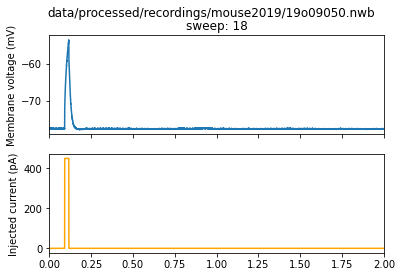

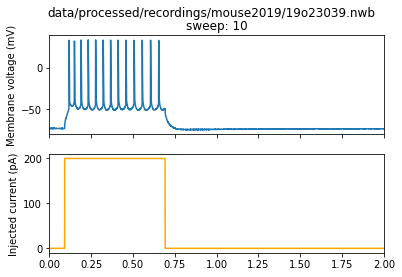

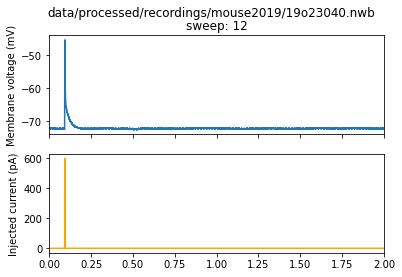

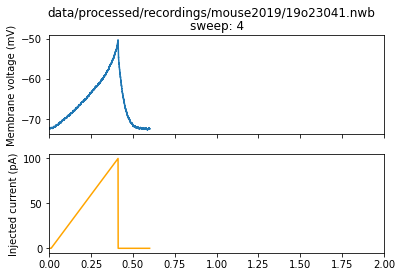

In [34]:
for i, row in successes_df.iterrows():
    utils.plot_nwb_sweep(row.nwb_path, './data/stim_ontology_new_Homeira.json') 

## Validate

In [35]:
!dandi validate "data/processed/recordings/mouse2019"

2021-07-28 15:28:10,375 [ WARNING] A newer version (0.25.0) of dandi/dandi-cli is available. You are using 0.23.2
2021-07-28 15:28:14,084 [    INFO] data/processed/recordings/mouse2019/19o09012.nwb: ok
2021-07-28 15:28:16,237 [    INFO] data/processed/recordings/mouse2019/19o23003.nwb: ok
2021-07-28 15:28:18,495 [    INFO] data/processed/recordings/mouse2019/19o23001.nwb: ok
2021-07-28 15:28:20,716 [    INFO] data/processed/recordings/mouse2019/19o23010.nwb: ok
2021-07-28 15:28:22,804 [    INFO] data/processed/recordings/mouse2019/2019_10_24_0035.nwb: ok
2021-07-28 15:28:24,929 [    INFO] data/processed/recordings/mouse2019/19o23039.nwb: ok
2021-07-28 15:28:27,405 [    INFO] data/processed/recordings/mouse2019/19o23005.nwb: ok
2021-07-28 15:28:29,426 [    INFO] data/processed/recordings/mouse2019/19o09017.nwb: ok
2021-07-28 15:28:31,539 [    INFO] data/processed/recordings/mouse2019/19o09016.nwb: ok
2021-07-28 15:28:34,035 [    INFO] data/processed/recordings/mouse2019/2019_10_24_0037.

## Extract stimulus info to later merge with metadata

In [36]:
converted_nwb_paths = list(Path('data/processed/recordings/mouse2019').glob('*.nwb'))

In [37]:
converted_nwb_file_ids = [x.stem for x in converted_nwb_paths]

In [38]:
to_extract_stim_info = mouse2019_file_info[mouse2019_file_info.file_id.isin(converted_nwb_file_ids)]

In [39]:
# parse relevant info related to stimulus, including duration, and amplitudes
def get_stim_info(abf_path, stim_channel_num = 1, stim_gain = 1, stim_name = 'sweepC'):
    abf = pyabf.ABF(abf_path)
    num_sweeps = abf.sweepCount
    stim_amps = np.zeros(num_sweeps) 
    stim_start_time = None
    stim_end_time = None
    sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

    for i in range(0, num_sweeps):
        abf.setSweep(i, channel=stim_channel_num)
        sampling_rate = abf.dataRate
        if stim_name == 'sweepY':
            stim_vec = np.round(abf.sweepY * stim_gain)
        else:
            stim_vec = np.round(abf.sweepC * stim_gain)
        stim_amp = stim_vec[5000]

        stim_amps[i] = round(stim_amp)
        non_zero_inds = np.where(stim_vec == stim_amp)
        stim_duration = np.shape(non_zero_inds)[1] * 1/sampling_rate
        if stim_duration == 0:
            continue
        stim_start_ind = non_zero_inds[0][0]
        stim_end_ind = non_zero_inds[0][-1]
        
        stim_start_time = abf.sweepX[stim_start_ind]
        stim_end_time = abf.sweepX[stim_end_ind]

    ret_dict = {'stim_amp_vec' : stim_amps, 'stim_duration' : stim_duration, 
                'stim_start_time' : stim_start_time, 'stim_end_time' : stim_end_time, 'num_sweeps' : num_sweeps,
               'stim_sampling_rate' : sampling_rate}
    return(ret_dict)
    """
    return pd.Series([stim_amps, stim_duration, stim_start_time, stim_end_time, num_sweeps, sampling_rate], 
                     index=['stim_amp_vec', 'stim_duration', 'stim_start_time', 'stim_end_time', 'num_sweeps', 'stim_sampling_rate'])
    """

In [40]:
stim_info = {}
for i, row in to_extract_stim_info.iterrows():
    try:
        abf_info = get_stim_info(row.path, stim_name = 'sweepC')
    except (AttributeError, ValueError, IndexError) as e:
        print(e)
        abf_info = None
    stim_info[row.file_name] = abf_info
    
stim_info_df = pd.DataFrame(stim_info).T

In [41]:
stim_info_df

,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
19o09012.abf,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2.6072,0.0,2.63215,8,20000
19o09049.abf,"[0.0, 12.0, 24.0, 35.0, 47.0, 59.0, 71.0, 83.0...",0.00068,0.19968,0.20032,25,25000
19o09050.abf,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.6072,0.0,2.63215,27,20000
19o09043.abf,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.6072,0.0,2.63215,18,20000
19o09042.abf,"[0.0, 12.0, 24.0, 35.0, 47.0, 59.0, 71.0, 83.0...",0.00116,0.19936,0.20048,15,25000
19o09058.abf,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.6072,0.0,2.63215,18,20000
19o09059.abf,"[0.0, 12.0, 24.0, 35.0, 47.0, 59.0, 71.0, 83.0...",0.001,0.19988,0.20084,17,25000
19o09057.abf,"[-300.0, -250.0, -200.0, -150.0, -100.0, -50.0...",0.6,0.0921,0.69205,14,20000
19o09016.abf,"[-300.0, -250.0, -200.0, -150.0, -100.0, -50.0...",0.6,0.0921,0.69205,16,20000
19o09017.abf,"[0.0, 12.0, 24.0, 35.0, 47.0, 59.0, 71.0, 83.0...",0.0016,0.19936,0.20092,11,25000


In [42]:
stim_info_dir = Path('./data/processed/meta/stiminfo/')
stim_info_dir.mkdir(exist_ok=True)
stim_info_df.index.name = 'abf_filename'
stim_info_df.to_csv(stim_info_dir / 'mouse2019_stiminfo.csv')